In [1]:
import sys
import os
import time
import warnings
import string

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapz
from statsmodels.tsa.stattools import acf 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib import rcParams
from cycler import cycler
from matplotlib import ticker
from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf
from structure_factor.tapers import multi_sinetaper_grid
from structure_factor.utils import meshgrid_to_column_matrix
from structure_factor.tapered_estimators import allowed_k_scattering_intensity, scattering_intensity, tapered_estimator_debiased_direct

import massPy as mp

from plot_utils import *
from utils import *
from AnalyseDefects_dev import AnalyseDefects

## Set plotting style and print options
plt.style.use('sg_article')
np.set_printoptions(precision = 5, suppress=1e-10)

In [2]:
def extract_ahu_results(obj, save = True,):
    """
    Analyse the defects for all the input folders
    """
    for N in range(obj.Ndata):
        print(f'Processing data set {N+1}/{obj.Ndata}...')

        kbins = np.loadtxt(os.path.join(obj.output_paths[N], 'kbins.txt'))
        rad = np.load(os.path.join(obj.output_paths[N], 'rad.npy'))

        sfac_full = np.nan * np.zeros((obj.Nframes[N], len(kbins), 2, obj.Nactivity[N], min(10, obj.Nexp[N])))
        sfac_pp = np.nan * np.zeros_like(sfac_full)
        sfac_mm = np.nan * np.zeros_like(sfac_full)
        sfac_pm = np.nan * np.zeros_like(sfac_full)

        pcf_full = np.nan * np.zeros((obj.Nframes[N], len(rad), obj.Nactivity[N], min(obj.Nexp[N], 10)))
        pcf_pp = np.nan * np.zeros_like(pcf_full)
        pcf_mm = np.nan * np.zeros_like(pcf_full)
        pcf_pm = np.nan * np.zeros_like(pcf_full)


        print('Analyse defects for input folder {}'.format(obj.input_paths[N]))
        for i, (act, act_dir) in enumerate(zip(obj.act_list[N], obj.act_dir_list[N])):
            print(f'Activity {i+1}/{obj.Nactivity[N]}: {act}')
            sfac_counter = 0
            exp_list = []
            exp_dir_list = []

            for file in os.listdir(act_dir):
                exp_count = file.split('_')[-1]
                exp_list.append(int(exp_count))
                exp_dir_list.append(os.path.join(act_dir, file))

            # sort the activity list and the activity directory list
            exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

            for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
      
                if sfac_counter < 10:
                    try:
                        sfac_full[-obj.Nframes[N]:, :, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'sfac.npy'))[-obj.Nframes[N]:, :,:]
                        sfac_pp[-obj.Nframes[N]:, :, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'sfac_pos.npy'))[-obj.Nframes[N]:, :,:]
                        sfac_mm[-obj.Nframes[N]:, :, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'sfac_neg.npy'))[-obj.Nframes[N]:, :,:]
                    except:
                        print(f'Error loading sfac for activity {act}, experiment {exp}. Skipping...')
                    try:
                        pcf_full[-obj.Nframes[N]:, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'pcf_arr.npy'))[-obj.Nframes[N]:, :,]
                        pcf_pp[-obj.Nframes[N]:, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'pcf_arr_pos.npy'))[-obj.Nframes[N]:, :,]
                        pcf_mm[-obj.Nframes[N]:, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'pcf_arr_neg.npy'))[-obj.Nframes[N]:, :,]
                        
                    except:
                        pass

                    sfac_counter += 1

        pcf_pm = 2 * pcf_full - pcf_pp - pcf_mm
        sfac_pm = sfac_full - 1/2 * (sfac_pp + sfac_mm)

        if save:
            np.save(os.path.join(obj.output_paths[N], 'sfac_full.npy'), sfac_full)
            np.save(os.path.join(obj.output_paths[N], 'sfac_pp.npy'), sfac_pp)
            np.save(os.path.join(obj.output_paths[N], 'sfac_mm.npy'), sfac_mm)
            np.save(os.path.join(obj.output_paths[N], 'sfac_pm.npy'), sfac_pm)
            np.save(os.path.join(obj.output_paths[N], 'pcf_full.npy'), pcf_full)
            np.save(os.path.join(obj.output_paths[N], 'pcf_pp.npy'), pcf_pp)
            np.save(os.path.join(obj.output_paths[N], 'pcf_mm.npy'), pcf_mm)
            np.save(os.path.join(obj.output_paths[N], 'pcf_pm.npy'), pcf_pm)
    return

def calc_time_av(obj, Ndataset, data_arr, temp_corr_arr, \
                    temp_corr_simple = True, ddof = 1, save_name = None,):
    """
    data_arr must have shape (Nframes, Nsomething, Nact, Nexp)
    returns an array of shape (Nsomething, Nact, 2)
    """

    Nframes, Nsomething, Nact, Nexp = data_arr.shape
    N = Ndataset
    time_av = np.nan * np.zeros((Nsomething, Nact, 2))
    
    for i in range(Nact):
        ff_idx = obj.conv_list[N][i]

        Nsamples = (Nframes - ff_idx) * np.ones((Nsomething, Nexp)) - np.nansum(np.isnan(data_arr[ff_idx:, :, i, :]),axis=(0))
        Nind_samples = np.nansum(Nsamples / temp_corr_arr[1 if temp_corr_simple else 0, :, i, :,], axis = -1)
    
        time_av[:, i, 0]  = np.nanmean(data_arr[obj.conv_list[N][i]:, :, i, :], axis = (0, -1))
        time_av[:, i, 1] = np.nanstd(data_arr[obj.conv_list[N][i]:, :, i, :], axis = (0, -1), ddof = ddof) / np.sqrt(Nind_samples)
    
    if save_name is not None:
        np.save(os.path.join(obj.output_paths[N], save_name + '.npy'), time_av)
        return
    else:
        return time_av

def produce_scaling(X, scaling_exp, Y0, x_bounds,):
    x = X[x_bounds[0]:x_bounds[1]]
    return x, Y0 * x**scaling_exp / x[0]**scaling_exp


In [3]:
LL = 2048

input_suffix = 'cs'
output_path_ref = f'data\\na{LL}'
output_path_new = f'data\\na{LL}{input_suffix}'
mode = 'all' # 'all' or 'short'

suffix_list = ['_full', '_pp', '_mm', '_pm']

defect_list = gen_analysis_dict(LL, mode)

for i in range(len(defect_list)):
    defect_list[i]['path'] = defect_list[i]['path'] + input_suffix
 
ad = AnalyseDefects(defect_list, output_path=output_path_new)

extract, analyze, merge = False, False, False

if extract:
    extract_ahu_results(ad, save=True)
if analyze:

    temp_corr_simple = True
    Nexp  = 5
    ddof = 1

    for i in range(ad.Ndata): 
        sfac_time_corr_arr = np.load(os.path.join(ad.output_paths[i], 'sfac.npz'))['corr_time_arr'][:, :, :, :Nexp]
        pcf_time_corr_arr = np.load(os.path.join(ad.output_paths[i], 'pcf.npz'))['corr_time_arr'][:, :, :, :Nexp]
        for j, suffix in enumerate(suffix_list):
            sfac_arr = np.load(os.path.join(ad.output_paths[i], 'sfac' + suffix + '.npy'))[:, :, 0, :, :]
            pcf_arr = np.load(os.path.join(ad.output_paths[i], 'pcf' + suffix + '.npy'))

            _ = calc_time_av(ad, i, sfac_arr, \
                                        sfac_time_corr_arr, temp_corr_simple = temp_corr_simple, ddof = ddof, \
                                        save_name = 'sfac_time_av' + suffix)
            _ = calc_time_av(ad, i, pcf_arr, \
                                        pcf_time_corr_arr, temp_corr_simple = temp_corr_simple, ddof = ddof, \
                                        save_name = 'pcf_time_av' + suffix) 
if merge:
    kbins, _, rad = ad.get_sfac_pcf()[:3]
    act_list = ad.act_list_merged

    Nact, Nkbins, Nrad = len(act_list), len(kbins), len(rad)
    Nact_min, Nact_max = 0, 0

    for j, suffix in enumerate(suffix_list):
        sfac_tav_merged = np.nan * np.zeros((Nkbins, Nact, 2))
        pcf_tav_merged = np.nan * np.zeros((Nrad, Nact, 2))
   
        Nact_min, Nact_max = 0, 0
        for i in reversed(range(ad.Ndata)):
            Nact_max += ad.Nactivity[i]

            sfac_tav_merged[:, Nact_min:Nact_max, :] = np.load(os.path.join(ad.output_paths[i], 'sfac_time_av' + suffix + '.npy')) #np.load(os.path.join(ad.output_paths[i], 'sfac_time_av' + suffix + '.npy'))
            pcf_tav_merged[:, Nact_min:Nact_max, :] = np.load(os.path.join(ad.output_paths[i], 'pcf_time_av' + suffix + '.npy'))
            Nact_min += ad.Nactivity[i]
        np.save(os.path.join(ad.output_merged, 'sfac_time_av_merged' + suffix + '.npy'), sfac_tav_merged) 
        np.save(os.path.join(ad.output_merged, 'pcf_time_av_merged' + suffix + '.npy'), pcf_tav_merged)
else:
    act_list_merged = ad.act_list_merged
    kbins, _, rad = ad.get_sfac_pcf()[:3]
    sf_full = np.load(os.path.join(ad.output_merged, 'sfac_time_av_merged_full.npy'))
    sf_pp = np.load(os.path.join(ad.output_merged, 'sfac_time_av_merged_pp.npy'))
    sf_mm = np.load(os.path.join(ad.output_merged, 'sfac_time_av_merged_mm.npy'))
    sf_pm = np.load(os.path.join(ad.output_merged, 'sfac_time_av_merged_pm.npy'))
    pcf_full = np.load(os.path.join(ad.output_merged, 'pcf_time_av_merged_full.npy'))
    pcf_pp = np.load(os.path.join(ad.output_merged, 'pcf_time_av_merged_pp.npy'))
    pcf_mm = np.load(os.path.join(ad.output_merged, 'pcf_time_av_merged_mm.npy'))
    pcf_pm = np.load(os.path.join(ad.output_merged, 'pcf_time_av_merged_pm.npy'))

    pcf_pm_post = 2 * pcf_full - pcf_pp - pcf_mm
    sf_pm_post = sf_full - 1/2 * (sf_pp + sf_mm)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_3300\81418043.py:72: RuntimeWarning: invalid value encountered in subtract
  pcf_pm_post = 2 * pcf_full - pcf_pp - pcf_mm
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_3300\81418043.py:73: RuntimeWarning: invalid value encountered in subtract
  sf_pm_post = sf_full - 1/2 * (sf_pp + sf_mm)


In [86]:
N=0
act_list = ad.act_list[N]
conv_list = ad.conv_list[N]
act = 0.028
act_idx = act_list.index(act)
sfac_full = np.load(os.path.join(ad.output_paths[N], 'sfac_full.npy'))
sfo = ad.get_sfac_pcf_full(0,)[1]
sfac_full[conv_list[act_idx]:, :, 0, act_idx, :].shape

(181, 50, 5)

In [16]:
import pandas as pd

csv_outdir = "C:\\Users\\Simon Andersen\\OneDrive - University of Copenhagen\\PhD\\Active Nematic Defect Transition\\data\\supplementary_information"
fig_name = "FigS1"
# initializa empty dataframe



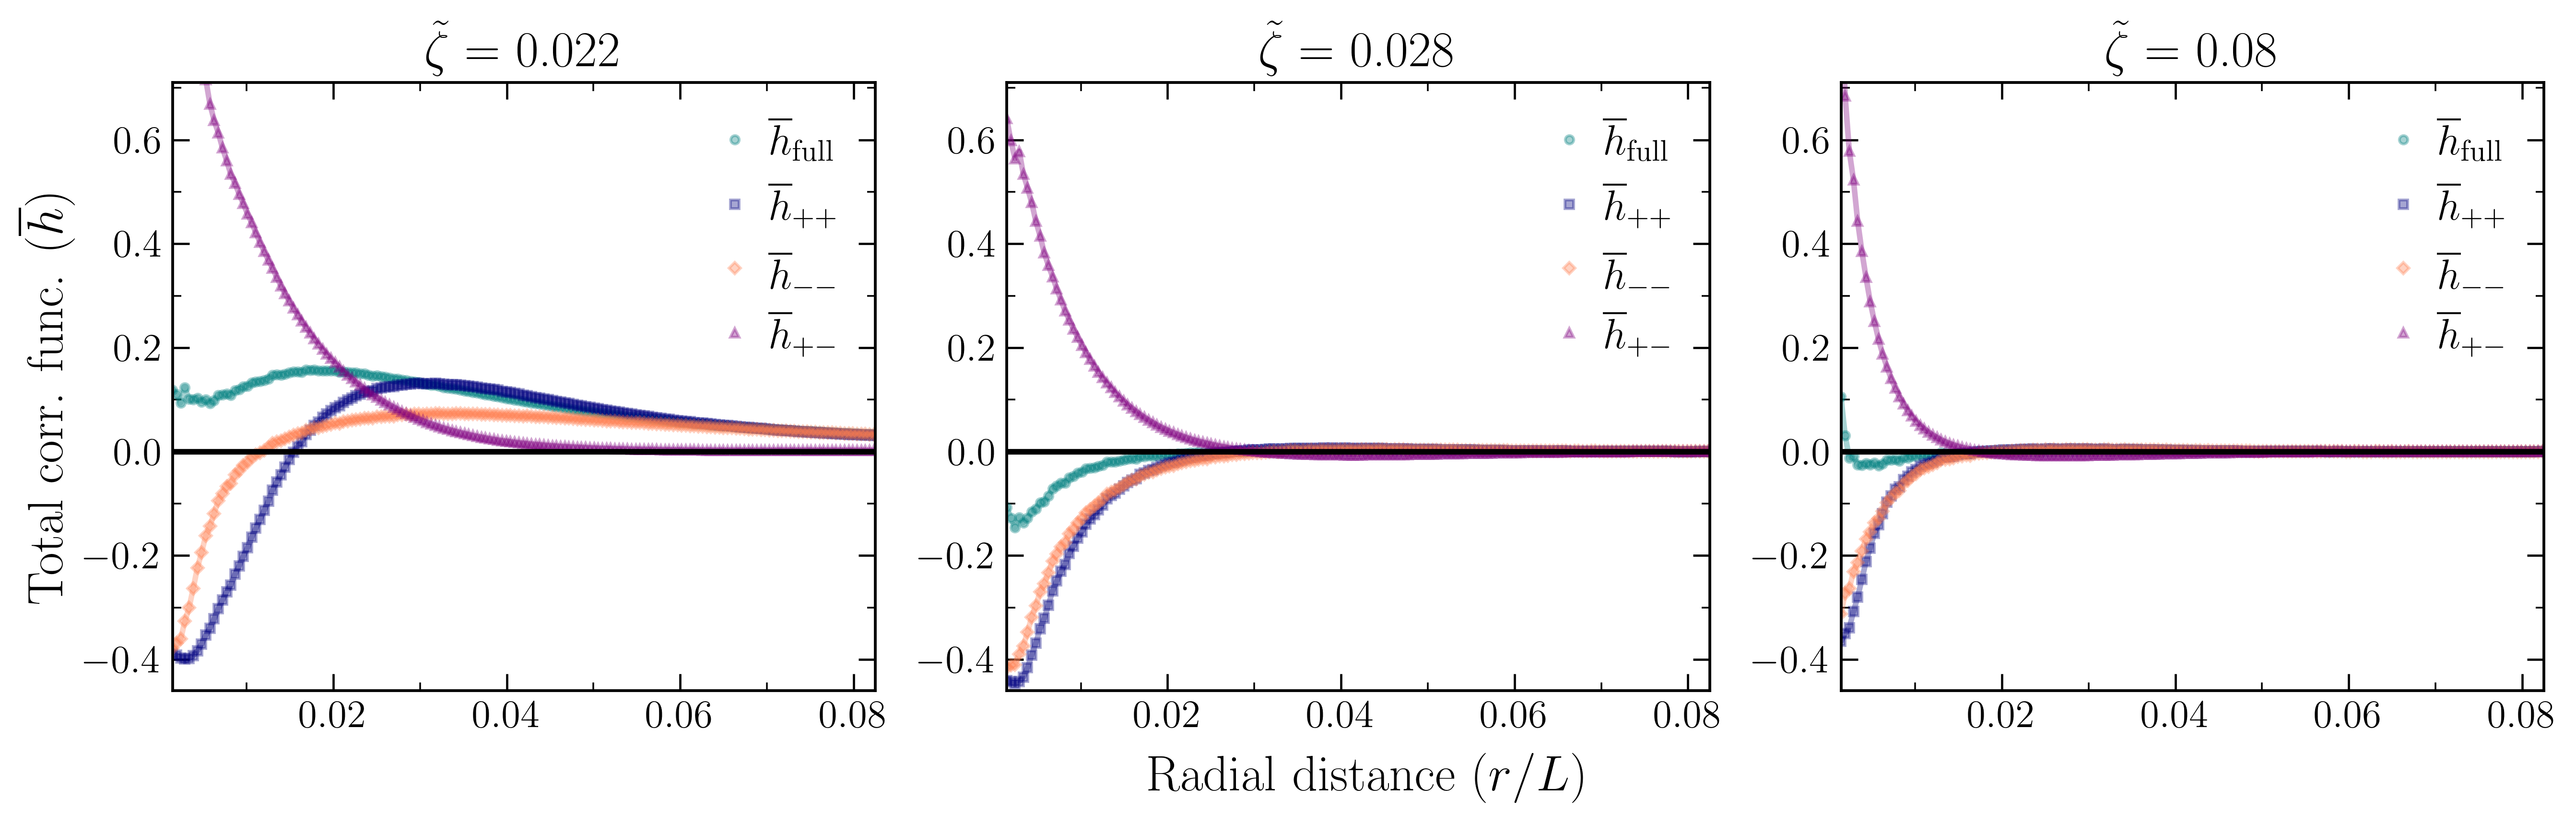

In [ ]:

plt.style.use('sg_article')
plt.rcParams['legend.handlelength'] = 0
plt.rcParams.update({"text.usetex": True,})
normalizer = 2048

act_list = [0.022, 0.028, 0.08]

marker_list = ['o', 's', 'D', '^', 'v', 'x', 'p', '*', 'h', '+']

ridx_min = 3

nrows = 1
width=13
height = 4.25 #width / 3.25 * nrows
fig0, ax0 = plt.subplots(nrows = nrows, ncols=3, figsize=(13, 4.25))#width, height))
ax0 = ax0.flatten()
kwargs = {'markersize': 3, 'alpha': .35}


for i, ax in enumerate(ax0):
    act_idx = np.where(act_list_merged == act_list[i])[0][0]
    #ax.text(0.03, 0.6, rf'$\tilde \zeta$ = {act_list_merged[act_idx]}', fontsize=16)
    ax.set_title(rf'$\tilde \zeta$ = {act_list_merged[act_idx]}')#, fontsize=16)
   # ax.set_xlabel(r'Radial distance $(r)$' if normalizer == 1 else r'Radial distance $(r / L)$')


    ax.plot(rad[ridx_min:] / normalizer, pcf_full[ridx_min:,act_idx,0]-1, label = r'$\overline h_{\mathrm{full}}$' if i < 3 else None, marker = marker_list[0], **kwargs)
    ax.plot(rad[ridx_min:] / normalizer, pcf_pp[ridx_min:,act_idx,0]-1, label =  r'$\overline h_{++}$' if i <3 else None, marker = marker_list[1], **kwargs)
    ax.plot(rad[ridx_min:] / normalizer, pcf_mm[ridx_min:,act_idx,0]-1, label = r'$\overline h_{-{-}}$' if i <3  else None, marker = marker_list[2], **kwargs)
    ax.plot(rad[ridx_min:] / normalizer, pcf_pm[ridx_min:,act_idx,0], label = r'$\overline h_{+-}$' if i < 3 else None, marker = marker_list[3], **kwargs)

    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))

    xvals, yvals = produce_scaling(rad / normalizer, -1.1, .025, (200, 450))

    xticks = [0.02, 0.04, 0.06, 0.08]
    ax.set_xticks(xticks, xticks)

    #ax.plot(xvals, yvals, label = r'$h_{+-} \sim r^{-2}$', color = 'k', linestyle = '--')
    ax.legend(loc='upper right', ncol=1)
    ax.hlines(0, rad[ridx_min] / normalizer, rad[-1] / normalizer, colors='k', linestyles='solid')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim(-.46, .71)
    ax.set_xlim(xmin=(ridx_min) / normalizer, xmax=0.825 * 204.8 / normalizer)#rad[-1])
    ax.tick_params(axis='both',which='major', labelsize=14)


    df = pd.DataFrame()
    csv_outdir = "C:\\Users\\Simon Andersen\\OneDrive - University of Copenhagen\\PhD\\Active Nematic Defect Transition\\data\\supplementary_information"
    fig_name = "FigS1"
    df['Radial distance (r/L)'] = rad[ridx_min:] / normalizer
    df['Total corr. func. (h_full)'] = pcf_full[ridx_min:,act_idx,0]-1
    df['Total corr. func. (h_pp)'] = pcf_pp[ridx_min:,act_idx,0]-1
    df['Total corr. func. (h_mm)'] = pcf_mm[ridx_min:,act_idx,0]-1
    df['Total corr. func. (h_pm)'] = pcf_pm[ridx_min:,act_idx,0]
    fig_name_suffix = '_left' if i == 0 else '_center' if i == 1 else '_right'
    df.to_csv(os.path.join(csv_outdir, fig_name + fig_name_suffix + '.csv'), index=False)


#fig0.legend(ncol=8, fontsize = 18, bbox_to_anchor=(0.53, 1.1), loc='upper center',)

fig0.supylabel(r'Total corr. func. ($\overline h$)',y=0.525)
fig0.supxlabel(r'Radial distance $(r / L)$' if normalizer == 1 else r'Radial distance $(r / L)$',\
                y=0.05, x=0.535, ha='center',)
fig0.tight_layout()


save_path0 = 'C:\\Users\\Simon Andersen\\OneDrive - University of Copenhagen\\PhD\\Active Nematic Defect Transition\\figs\\SI'
if not os.path.exists(save_path0):
    os.makedirs(save_path0)
if 0:
    fig0.savefig(os.path.join(save_path0, f"figure_pcf_signed.jpeg"), dpi=620)#dpi=420)
    fig0.savefig(os.path.join(save_path0, f"figure_pcf_signed.eps"))#dpi=420)


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_3300\4032296648.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin=0, xmax=kbins[-1])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_3300\4032296648.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin=0, xmax=kbins[-1])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_3300\4032296648.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin=0, xmax=kbins[-1])


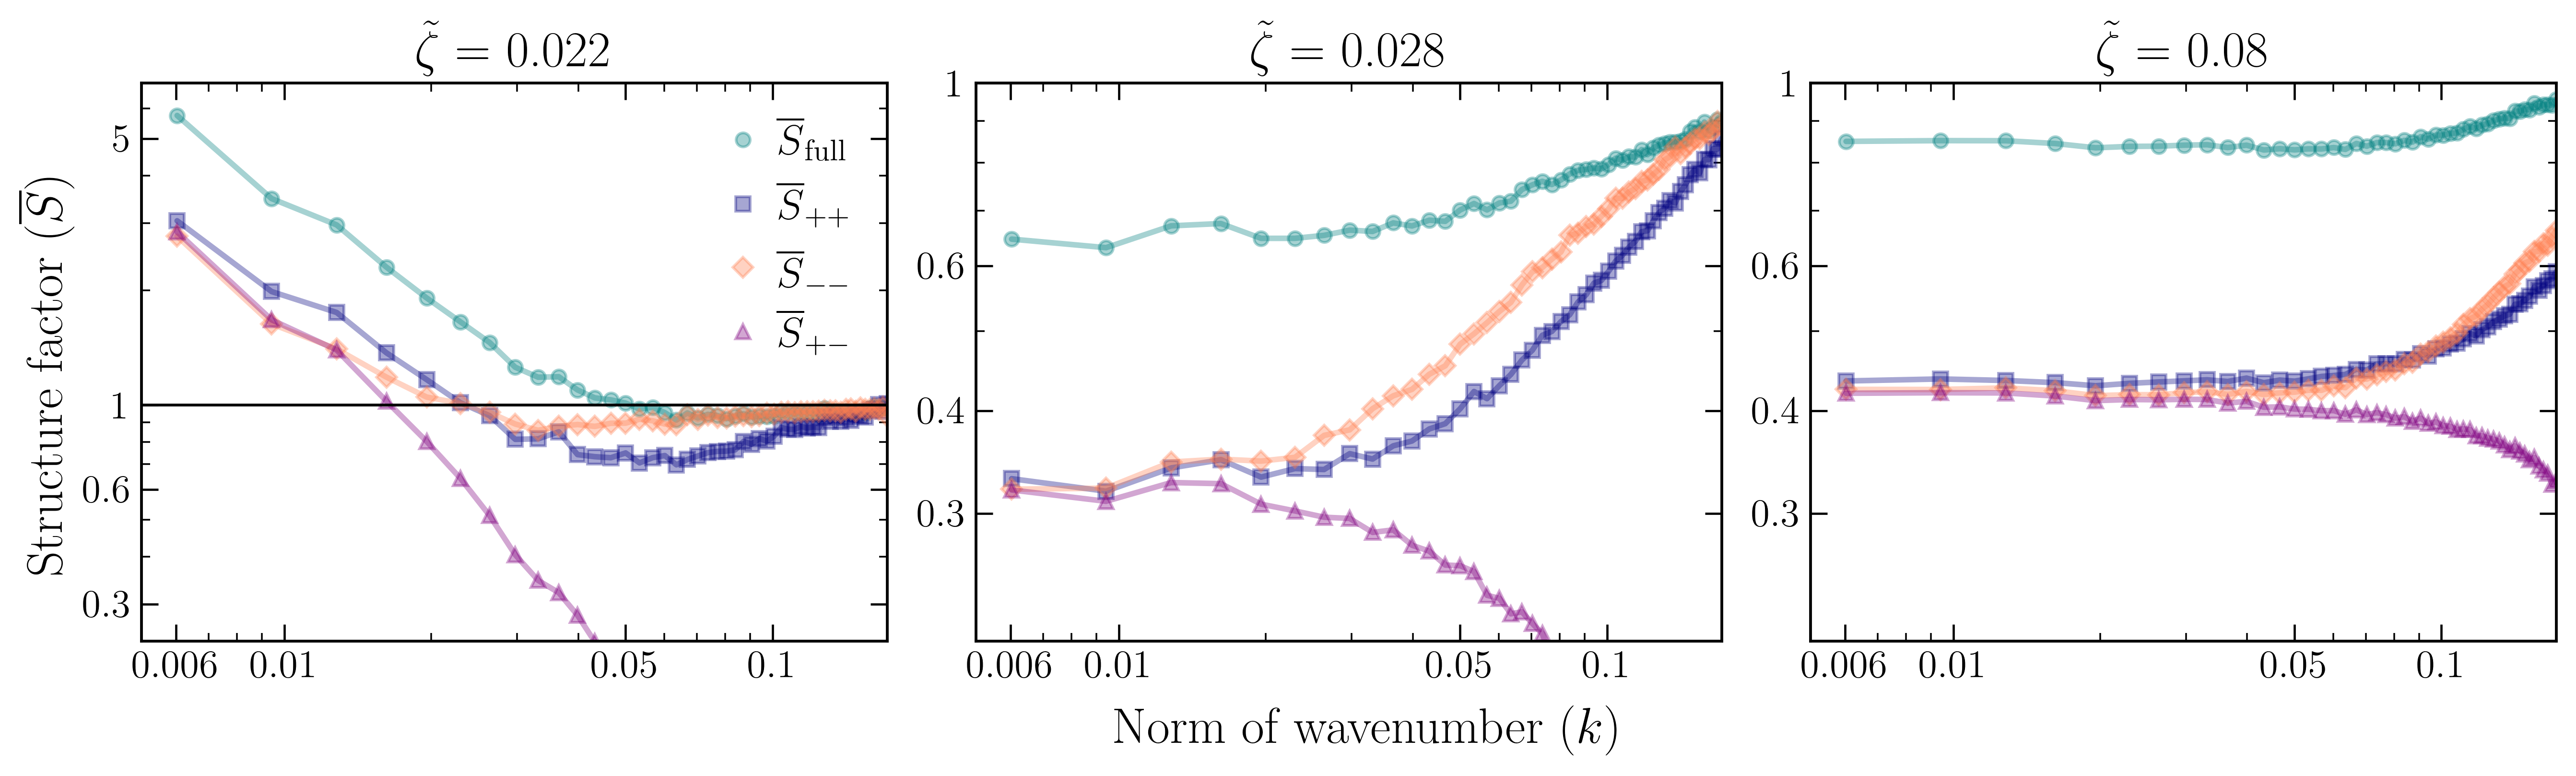

In [ ]:
plt.style.use('sg_article')
plt.rcParams['legend.handlelength'] = 0
plt.rcParams.update({"text.usetex": True,})

act_list = [0.022, 0.028, 0.08]

marker_list = ['o', 's', 'D', '^', 'v', 'x', 'p', '*', 'h', '+']

kbins_min = 0

nrows = 1
width=13
height = 4
fig0, ax0 = plt.subplots(nrows = nrows, ncols=3, figsize=(width, height))
ax0 = ax0.flatten()
kwargs = {'markersize': 5, 'alpha': .35}

for i, ax in enumerate(ax0):
    act_idx = np.where(act_list_merged == act_list[i])[0][0]
    ax.set_title(rf'$\tilde \zeta$ = {act_list_merged[act_idx]}')
  #  ax.set_ylabel(r'Structure factor ($\overline S$)')
  #  ax.set_xlabel(r'Norm of wavenumber $(k)$')
    ax.plot(kbins[kbins_min:], sf_full[kbins_min:,act_idx,0], label = r'$\overline S_{\mathrm{full}}$' if i==0 else None, marker = marker_list[0], **kwargs)
    ax.plot(kbins[kbins_min:], sf_pp[kbins_min:,act_idx,0], label =  r'$\overline S_{++}$' if i==0 else None, marker = marker_list[1], **kwargs)
    ax.plot(kbins[kbins_min:], sf_mm[kbins_min:,act_idx,0], label = r'$\overline S_{-{-}}$' if i==0 else None, marker = marker_list[2], **kwargs)
    ax.plot(kbins[kbins_min:], sf_pm_post[kbins_min:,act_idx,0], label = r'$\overline S_{+-}$' if i==0 else None, marker = marker_list[3], **kwargs)

    xvals, yvals = produce_scaling(rad, -1.1, .025, (200, 450))
    #ax.plot(xvals, yvals, label = r'$h_{+-} \sim r^{-2}$', color = 'k', linestyle = '--')
    ax.legend(ncols=1,loc='upper right', fontsize=15)
    ax.hlines(1, 0, kbins[-1], colors='k', linestyles='solid', lw=1)

    ax.set_xscale('log')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_yscale('log')

    yticks = []
    ax.set_yticks(yticks, yticks)

    xticks = [0.006, 0.01, 0.05, 0.1,]
    yticks = [0.3, .6, 1, 5] if i == 0 else [0.3, 0.4, 0.6,1]
    ax.set_yticks(yticks, yticks)
    ax.set_xticks(xticks, xticks)

    ax.set_xlim(xmin=0, xmax=kbins[-1])
    ax.set_ylim(ymin=0.21 if i !=0 else 0.24, ymax=7 if i == 0 else 1)
   # ax.set_ylim(ymin=0.25, ymax=6.5)
    ax.tick_params(axis='both',which='major', labelsize=14 )

    df = pd.DataFrame()
    csv_outdir = "C:\\Users\\Simon Andersen\\OneDrive - University of Copenhagen\\PhD\\Active Nematic Defect Transition\\data\\supplementary_information"
    fig_name = "FigS2"
    df['Norm of wavenumber (k)'] = kbins[kbins_min:]
    df['Structure factor (S)'] = sf_full[kbins_min:,act_idx,0]
    df['Structure factor (S_pp)'] = sf_pp[kbins_min:,act_idx,0]
    df['Structure factor (S_mm)'] = sf_mm[kbins_min:,act_idx,0]
    df['Structure factor (S_pm)'] = sf_pm_post[kbins_min:,act_idx,0]

    fig_name_suffix = '_left' if i == 0 else '_center' if i == 1 else '_right'
    df.to_csv(os.path.join(csv_outdir, fig_name + fig_name_suffix + '.csv'), index=False)
    

fig0.supylabel(r'Structure factor ($\overline S$)',y=0.525)
fig0.supxlabel(r'Norm of wavenumber $(k)$', y=0.05, x=0.535, ha='center',)

save_path0 = 'C:\\Users\\Simon Andersen\\OneDrive - University of Copenhagen\\PhD\\Active Nematic Defect Transition\\figs\\SI'
if not os.path.exists(save_path0):
    os.makedirs(save_path0)
if 0:
    fig0.savefig(os.path.join(save_path0, f"figure_sfac_signed.jpeg"), dpi=620)#dpi=420)
    fig0.savefig(os.path.join(save_path0, f"figure_sfac_signed.eps"))#dpi=420)

